# Import Dependencies
## Required
### rioxarray (Will get xarray and other dependencies as needed)
### geopandas

In [1]:
import os
import glob
import time
import math

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping

## Set path to the grace dir here

In [2]:
grace_dir = '/home/dev/grace_dir/'

In [3]:
# Reading the NW Bangladesh shapefile
gdf = gpd.read_file(os.path.join(grace_dir, 'NorthWestBD.shp'))
gdf

,OBJECTID,Shape_Leng,Shape_Area,geometry
0,1,18.876597,3.089947,"MULTIPOLYGON (((88.93296 26.33316, 88.93322 26..."


# Start GLDAS Processing

In [4]:
# Load Concatenated GLDAS Model Files
gldas_vic_ds = xr.open_dataset(os.path.join(grace_dir, 'vic.nc'))
gldas_clsm_ds = xr.open_dataset(os.path.join(grace_dir, 'clsm.nc'))
gldas_noah_ds = xr.open_dataset(os.path.join(grace_dir,'noah.nc'))

In [5]:
# Clip GLDAS Model file to given GeoDataFrame
def clip_gldas_ds(ds, gdf): 
    # Looping through the variables and setting a spatial dimension so that they can be clipped
    for var in ds.variables:
        if var not in ['lat', 'lon', 'time']:
            ds[var] = ds[var].rio.write_crs("epsg:4326") 
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    clipped_ds = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
    return clipped_ds

In [6]:
# Calculate Surface Area of Grid Cell
def calculate_surface_area(ds):
    # Find the lon size
    lon_interval_size = ds.variables['lon'][1] - ds.variables['lon'][0]
    # Find the lat size
    lat_interval_size = ds.variables['lat'][1] - ds.variables['lat'][0]
    surface_area_array = np.array([6371000*math.radians(lat_interval_size)*6371000*math.radians(lon_interval_size)*math.cos(math.radians(lat)) for lat in ds.lat.values])
    return surface_area_array

In [7]:
# Unit Factors Dict
unit_factors = {"mm": 1000, "kg/m2": 1000, "kg/m^2": 1000, "cm": 100, "dm": 10, "m": 1, "km": .001, "kg m-2": 1000}

In [8]:
# For a given gldas dataset and surface area data array calculate anomalies for each variable
def calculate_gldas_anomalies(ds, surface_area_da):
    for var in ds.variables:
        if var not in ['lat', 'lon', 'time', 'spatial_ref']:
            # Calculate variable mean from 2004 to 2009
            var_mean = ds.sel(time=slice('2004-01-01', '2009-12-31')).mean('time')[var]
#             ds.sel(time=slice('2004-01-01', '2009-12-31')).mean('time')[var]
            var_factor = unit_factors[ds[var].units]
            ds[var] = (ds[var] - var_mean)/var_factor * surface_area_da
            ds[var] = ds[var]*100/surface_area_da
    return ds

In [9]:
# Clipped GLDAS Model Files
gldas_vic_ds = clip_gldas_ds(gldas_vic_ds, gdf)
gldas_clsm_ds = clip_gldas_ds(gldas_clsm_ds, gdf)
gldas_noah_ds = clip_gldas_ds(gldas_noah_ds, gdf)

In [10]:
gldas_vic_ds.CanopInt_inst

<xarray.DataArray 'CanopInt_inst' (time: 253, lat: 3, lon: 2)>
array([[[4.4795391e-03, 5.8432859e-03],
        [          nan, 4.9741324e-03],
        [1.6314936e-03,           nan]],

       [[4.6360674e-03, 6.0724551e-03],
        [          nan, 2.8319203e-03],
        [1.9860514e-03,           nan]],

       [[3.9738659e-03, 1.0312374e-02],
        [          nan, 6.0620140e-03],
        [1.2444491e-03,           nan]],

       ...,

       [[2.6973630e-03, 5.9376070e-03],
        [          nan, 3.8915239e-03],
        [3.0699957e-03,           nan]],

       [[6.1404699e-04, 3.2297478e-04],
        [          nan, 1.3766765e-03],
        [6.0483871e-06,           nan]],

       [[1.0117865e-03, 9.9555170e-04],
        [          nan, 9.1912842e-04],
        [0.0000000e+00,           nan]]], dtype=float32)
Coordinates:
  * lat          (lat) float64 24.5 25.5 26.5
  * lon          (lon) float64 88.5 89.5
  * time         (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2021-01-01
    spatial_ref  int64 0
Attributes:
    standard_name:  canopy_water_amount
    long_name:      Plant canopy surface water
    units:          kg m-2
    cell_methods:   time: mean
    vmin:           0.0
    vmax:           0.8526354

In [11]:
gldas_clsm_ds

<xarray.Dataset>
Dimensions:           (lat: 3, lon: 2, time: 253)
Coordinates:
  * lat               (lat) float64 24.5 25.5 26.5
  * lon               (lon) float64 88.5 89.5
  * time              (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2021-01-01
    spatial_ref       int64 0
Data variables:
    SWE_inst          (time, lat, lon) float32 0.0 0.0 nan 0.0 ... 0.0 0.0 nan
    CanopInt_inst     (time, lat, lon) float32 0.01136 0.01191 ... 0.0009293 nan
    TWS_inst          (time, lat, lon) float32 989.2 1.093e+03 ... 1.121e+03 nan
    SoilMoist_P_inst  (time, lat, lon) float32 989.2 1.093e+03 ... 1.121e+03 nan
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-09T16:18:11.303
    source:                 CLSM_F2.5 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [12]:
gldas_noah_ds

<xarray.Dataset>
Dimensions:                (lat: 3, lon: 2, time: 253)
Coordinates:
  * lat                    (lat) float64 24.5 25.5 26.5
  * lon                    (lon) float64 88.5 89.5
  * time                   (time) datetime64[ns] 2000-01-01 ... 2021-01-01
    spatial_ref            int64 0
Data variables:
    SWE_inst               (time, lat, lon) float32 0.0 0.0 nan ... 0.0 0.0 nan
    CanopInt_inst          (time, lat, lon) float32 0.01098 0.01813 ... nan
    SoilMoi0_10cm_inst     (time, lat, lon) float32 20.06 21.51 ... 19.49 nan
    SoilMoi10_40cm_inst    (time, lat, lon) float32 66.19 69.25 nan ... 63.1 nan
    SoilMoi40_100cm_inst   (time, lat, lon) float32 145.5 151.0 ... 138.1 nan
    SoilMoi100_200cm_inst  (time, lat, lon) float32 273.2 279.0 ... 262.4 nan
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-09T16:06:53.375
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [13]:
# GLDAS Grid Cell Area
areas = calculate_surface_area(gldas_clsm_ds)

surface_area_da = (xr.DataArray(areas, dims=['lat'],
                                coords={'lat': gldas_clsm_ds.lat})
                   .expand_dims(lon=len(gldas_clsm_ds.coords['lon']))
                   .assign_coords(lon=gldas_clsm_ds.lon)
                   .transpose('lat', 'lon')
#                    .drop('spatial_ref')
                  )
surface_area_da

<xarray.DataArray (lat: 3, lon: 2)>
array([[1.12510448e+10, 1.12510448e+10],
       [1.11598458e+10, 1.11598458e+10],
       [1.10652474e+10, 1.10652474e+10]])
Coordinates:
  * lat          (lat) float64 24.5 25.5 26.5
    spatial_ref  int64 0
  * lon          (lon) float64 88.5 89.5

In [14]:
# Calculate Anomalies for each model
gldas_clsm_anomalies = calculate_gldas_anomalies(gldas_clsm_ds, surface_area_da)
gldas_noah_anomalies = calculate_gldas_anomalies(gldas_noah_ds, surface_area_da)
gldas_vic_anomalies = calculate_gldas_anomalies(gldas_vic_ds, surface_area_da)

In [15]:
gldas_clsm_anomalies

<xarray.Dataset>
Dimensions:           (lat: 3, lon: 2, time: 253)
Coordinates:
  * lat               (lat) float64 24.5 25.5 26.5
  * lon               (lon) float64 88.5 89.5
  * time              (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2021-01-01
    spatial_ref       int64 0
Data variables:
    SWE_inst          (time, lat, lon) float64 0.0 0.0 nan 0.0 ... 0.0 0.0 nan
    CanopInt_inst     (time, lat, lon) float64 -0.0008521 -0.001237 ... nan
    TWS_inst          (time, lat, lon) float64 -6.134 1.641 nan ... 4.258 nan
    SoilMoist_P_inst  (time, lat, lon) float64 -6.132 1.642 nan ... 4.262 nan
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-09T16:18:11.303
    source:                 CLSM_F2.5 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [16]:
gldas_noah_anomalies

<xarray.Dataset>
Dimensions:                (lat: 3, lon: 2, time: 253)
Coordinates:
  * lat                    (lat) float64 24.5 25.5 26.5
  * lon                    (lon) float64 88.5 89.5
  * time                   (time) datetime64[ns] 2000-01-01 ... 2021-01-01
    spatial_ref            int64 0
Data variables:
    SWE_inst               (time, lat, lon) float64 0.0 0.0 nan ... 0.0 0.0 nan
    CanopInt_inst          (time, lat, lon) float64 -0.009269 -0.009541 ... nan
    SoilMoi0_10cm_inst     (time, lat, lon) float64 -0.5768 -0.5066 ... nan
    SoilMoi10_40cm_inst    (time, lat, lon) float64 -1.4 -1.278 ... -1.97 nan
    SoilMoi40_100cm_inst   (time, lat, lon) float64 -1.889 -1.662 ... -3.151 nan
    SoilMoi100_200cm_inst  (time, lat, lon) float64 -3.471 -3.365 ... -4.929 nan
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-09T16:06:53.375
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [17]:
gldas_vic_anomalies

<xarray.Dataset>
Dimensions:              (lat: 3, lon: 2, time: 253)
Coordinates:
  * lat                  (lat) float64 24.5 25.5 26.5
  * lon                  (lon) float64 88.5 89.5
  * time                 (time) datetime64[ns] 2000-01-01 ... 2021-01-01
    spatial_ref          int64 0
Data variables:
    SWE_inst             (time, lat, lon) float64 0.0 0.0 nan ... 0.0 0.0 nan
    CanopInt_inst        (time, lat, lon) float64 -0.002262 -0.002365 ... nan
    SoilMoi0_30cm_inst   (time, lat, lon) float64 -2.197 -2.184 ... -2.561 nan
    SoilMoi_depth2_inst  (time, lat, lon) float64 -15.17 -5.777 ... -12.08 nan
    SoilMoi_depth3_inst  (time, lat, lon) float64 0.4509 1.31 nan ... 0.7597 nan
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2020-02-03T12:00:52.166
    source:                 VIC_v4.1.2 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [18]:
# Declare TWS variables that need to be summed

clsm_tws_variables = ['SWE_inst', 'CanopInt_inst', 'SoilMoist_P_inst']

noah_tws_variables = ['SWE_inst', 'CanopInt_inst', 'SoilMoi0_10cm_inst',
                      'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst',
                      'SoilMoi100_200cm_inst'
                     ]

vic_tws_variables = ['SWE_inst', 'CanopInt_inst', 
                     'SoilMoi0_30cm_inst', 'SoilMoi_depth2_inst',
                     'SoilMoi_depth3_inst'
                    ]

In [19]:
# Declare Surface Water Variables
clsm_sw_variables = ['SWE_inst', 'CanopInt_inst']

noah_sw_variables = ['SWE_inst', 'CanopInt_inst']

vic_sw_variables = ['SWE_inst', 'CanopInt_inst']

In [20]:
# Declare Snow Water Equivalent Variables
clsm_swe_variables = ['SWE_inst']

noah_swe_variables = ['SWE_inst']

vic_swe_variables = ['SWE_inst']

In [21]:
# Declare Canopy Variables
clsm_canopy_variables = ['CanopInt_inst']

noah_canopy_variables = ['CanopInt_inst']

vic_canopy_variables = ['CanopInt_inst']

In [22]:
# Declare Soil Moisture variables
clsm_sm_variables = ['SoilMoist_P_inst']

noah_sm_variables = ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst',
                      'SoilMoi100_200cm_inst']

vic_sm_variables = ['SoilMoi0_30cm_inst', 'SoilMoi_depth2_inst', 'SoilMoi_depth3_inst']

In [23]:
def aggregate_gldas_anomalies(clsm_variables, noah_variables, vic_variables, variable_name):
    clsm_ds = gldas_clsm_anomalies[clsm_variables].to_array().sum('variable').to_dataset(name=variable_name)
    noah_ds = gldas_noah_anomalies[noah_variables].to_array().sum('variable').to_dataset(name=variable_name)
    vic_ds = gldas_vic_anomalies[vic_variables].to_array().sum('variable').to_dataset(name=variable_name)
    # create a new dataset with all the model tws mean values
    # returns a single value at each time step
    model_ds = xr.Dataset({
        'clsm': clsm_ds[variable_name].mean(['lat', 'lon']),
        'noah': noah_ds[variable_name].mean(['lat', 'lon']),
        'vic': vic_ds[variable_name].mean(['lat', 'lon'])
    })
    # calculate the TWS mean and stddev across the three models
    model_mean = model_ds.to_array().mean('variable').values
    model_std = model_ds.to_array().std('variable').values
    
    # create a final netcdf array with the mean and std values
    final_ds = (xr.Dataset(data_vars={f'mean_{variable_name}': (["time"], model_mean),
                                      f'std_{variable_name}': (["time"], model_std)
                                     },
                           coords={"time":vic_ds.coords['time']})
                .expand_dims(lat=len(vic_ds.coords['lat']), lon=len(vic_ds.coords['lon']))
                .assign_coords(lat=vic_ds.coords['lat'], lon=vic_ds.coords['lon']))
    return final_ds

In [24]:
final_tws_ds = aggregate_gldas_anomalies(clsm_tws_variables, noah_tws_variables, vic_tws_variables, 'tws')

In [25]:
final_sw_ds = aggregate_gldas_anomalies(clsm_sw_variables, noah_sw_variables, vic_sw_variables, 'sw')

In [26]:
final_sm_ds = aggregate_gldas_anomalies(clsm_sm_variables, noah_sm_variables, vic_sm_variables, 'sm')

In [27]:
final_canopy_ds = aggregate_gldas_anomalies(clsm_canopy_variables, noah_canopy_variables, vic_canopy_variables, 'canopy')

In [28]:
final_swe_ds = aggregate_gldas_anomalies(clsm_swe_variables, noah_swe_variables, vic_swe_variables, 'swe')

In [29]:
tws_df = final_tws_ds.mean_tws.to_dataframe().reset_index()[['time', 'mean_tws']].drop_duplicates()
tws_df

,time,mean_tws
0,2000-01-01,-3.761522
1,2000-02-01,-7.612675
2,2000-03-01,-12.655033
3,2000-04-01,-15.109357
4,2000-05-01,-8.470782
...,...,...
248,2020-09-01,15.017552
249,2020-10-01,13.221290
250,2020-11-01,5.768155
251,2020-12-01,0.015571


In [30]:
tws_std_df = final_tws_ds.std_tws.to_dataframe().reset_index()[['time', 'std_tws']].drop_duplicates()
tws_std_df

,time,std_tws
0,2000-01-01,2.038648
1,2000-02-01,1.773507
2,2000-03-01,2.230922
3,2000-04-01,4.142180
4,2000-05-01,6.261489
...,...,...
248,2020-09-01,2.478384
249,2020-10-01,4.363169
250,2020-11-01,4.192047
251,2020-12-01,3.194324


In [31]:
sm_std_df = final_sm_ds.std_sm.to_dataframe().reset_index()[['time', 'std_sm']].drop_duplicates()
sm_std_df

,time,std_sm
0,2000-01-01,2.037270
1,2000-02-01,1.774064
2,2000-03-01,2.233062
3,2000-04-01,4.141858
4,2000-05-01,6.259688
...,...,...
248,2020-09-01,2.481580
249,2020-10-01,4.362380
250,2020-11-01,4.189594
251,2020-12-01,3.191927


In [32]:
sw_std_df = final_sw_ds.std_sw.to_dataframe().reset_index()[['time', 'std_sw']].drop_duplicates()
sw_std_df

,time,std_sw
0,2000-01-01,0.002708
1,2000-02-01,0.001544
2,2000-03-01,0.002144
3,2000-04-01,0.000355
4,2000-05-01,0.002455
...,...,...
248,2020-09-01,0.003472
249,2020-10-01,0.000799
250,2020-11-01,0.002496
251,2020-12-01,0.002753


In [33]:
swe_std_df = final_swe_ds.std_swe.to_dataframe().reset_index()[['time', 'std_swe']].drop_duplicates()
swe_std_df

,time,std_swe
0,2000-01-01,0.000002
1,2000-02-01,0.000000
2,2000-03-01,0.000000
3,2000-04-01,0.000000
4,2000-05-01,0.000000
...,...,...
248,2020-09-01,0.000000
249,2020-10-01,0.000000
250,2020-11-01,0.000000
251,2020-12-01,0.000000


In [34]:
canopy_std_df = final_canopy_ds.std_canopy.to_dataframe().reset_index()[['time', 'std_canopy']].drop_duplicates()
canopy_std_df

,time,std_canopy
0,2000-01-01,0.002710
1,2000-02-01,0.001544
2,2000-03-01,0.002144
3,2000-04-01,0.000355
4,2000-05-01,0.002455
...,...,...
248,2020-09-01,0.003472
249,2020-10-01,0.000799
250,2020-11-01,0.002496
251,2020-12-01,0.002753


# Start Grace Processing

In [35]:
# Open GRACE netcdf file
grace_ds = xr.open_dataset(os.path.join(grace_dir, 'latest_jpl_grace.nc'))[['lwe_thickness', 'uncertainty']]

In [36]:
# Clipping the grace ds to utah shapefile
ds = grace_ds.copy()
ds = ds.assign({"lon": (((ds.lon + 180) % 360) - 180)}).sortby('lon')
ds['lwe_thickness'] = ds['lwe_thickness'].rio.write_crs("epsg:4326")
ds['uncertainty'] = ds['uncertainty'].rio.write_crs("epsg:4326")
ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
grace_clipped = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

In [37]:
grace_clipped

<xarray.Dataset>
Dimensions:        (lat: 5, lon: 4, time: 195)
Coordinates:
  * lat            (lat) float64 24.25 24.75 25.25 25.75 26.25
  * lon            (lon) float64 88.25 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-03-16T1...
    WGS84          int64 0
Data variables:
    lwe_thickness  (time, lat, lon) float64 nan -11.94 -14.36 ... -55.73 nan nan
    uncertainty    (time, lat, lon) float64 nan 22.89 22.97 ... 11.68 nan nan
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2021-04-27T21:04:06Z

In [38]:
# Clipping Scale Factors NetCDF file
sf_ds = xr.open_dataset(os.path.join(grace_dir, 'scale_factors.nc'))
sf_ds = sf_ds.assign({"lon": (((sf_ds.lon + 180) % 360) - 180)}).sortby('lon')
sf_ds['scale_factor'] = sf_ds['scale_factor'].rio.write_crs("epsg:4326")
sf_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
sf_clipped = sf_ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

In [39]:
# Calculate GRACE grid cell area
grace_areas = calculate_surface_area(sf_clipped)

In [40]:
# Convert array to xarray dataarray
grace_area_da = xr.DataArray(grace_areas, dims=['lat'], coords={'lat': sf_clipped.lat}).expand_dims(lon=len(sf_clipped.coords['lon'])).assign_coords(lon=sf_clipped.lon)

In [41]:
sf_clipped['surface_area'] = grace_area_da.transpose('lat', 'lon')

In [42]:
# Calculate GRACE TWS Anomalies

# Calculate grid cell long term mean
grid_cell_mean = grace_clipped.mean('time').lwe_thickness
# grace_clipped.sel(time=slice('2004-01-01', '2009-12-31')).mean('time').lwe_thickness
# Calculate anamolies based on grid cell mean, scale factor and surface area
gw_wsa_da = (grace_clipped.lwe_thickness - grid_cell_mean) * sf_clipped.scale_factor
final_gw_da = gw_wsa_da.copy()

In [43]:
final_gw_da

<xarray.DataArray (time: 195, lat: 5, lon: 4)>
array([[[         nan,  -7.13845266, -17.26486904, -17.26486904],
        [ -7.13845266,  -7.13845266, -17.26486904, -17.26486904],
        [         nan,          nan, -16.10406004, -16.10406004],
        [         nan,   9.88780363,   9.74180973,   9.74180973],
        [         nan,   8.38552132,          nan,          nan]],

       [[         nan,  -4.14765822, -10.76105615, -10.76105615],
        [ -4.14765822,  -4.14765822, -10.76105615, -10.76105615],
        [         nan,          nan, -10.03753309, -10.03753309],
        [         nan,  19.8869995 ,  19.59336698,  19.59336698],
        [         nan,  16.86551073,          nan,          nan]],

       [[         nan,  44.00830982,  46.14480162,  46.14480162],
        [ 44.00830982,  44.00830982,  46.14480162,  46.14480162],
        [         nan,          nan,  43.04224109,  43.04224109],
        [         nan,  85.58717298,  84.3234742 ,  84.3234742 ],
        [         nan,  72.58366878,          nan,          nan]],

       ...,

       [[         nan,  -4.41044406,  -5.50066862,  -5.50066862],
        [ -4.41044406,  -4.41044406,  -5.50066862,  -5.50066862],
        [         nan,          nan,  -5.1308294 ,  -5.1308294 ],
        [         nan, -57.61131673, -56.76068283, -56.76068283],
        [         nan, -48.85826445,          nan,          nan]],

       [[         nan, -14.13358007, -13.05841543, -13.05841543],
        [-14.13358007, -14.13358007, -13.05841543, -13.05841543],
        [         nan,          nan, -12.18042869, -12.18042869],
        [         nan, -66.05507172, -65.07976537, -65.07976537],
        [         nan, -56.01913557,          nan,          nan]],

       [[         nan, -23.86105221, -20.29507514, -20.29507514],
        [-23.86105221, -23.86105221, -20.29507514, -20.29507514],
        [         nan,          nan, -18.93052925, -18.93052925],
        [         nan, -65.60048502, -64.63189066, -64.63189066],
        [         nan, -55.63361553,          nan,          nan]]])
Coordinates:
  * lat          (lat) float64 24.25 24.75 25.25 25.75 26.25
  * lon          (lon) float64 88.25 88.75 89.25 89.75
  * time         (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-03-16T12:...
    WGS84        int64 0
    spatial_ref  int64 0

In [44]:
final_gw_da.mean(['lat', 'lon']).to_dataframe(name='twsa').reset_index()

,time,WGS84,spatial_ref,twsa
0,2002-04-17 12:00:00,0,0,-6.532770
1,2002-05-10 12:00:00,0,0,0.028998
2,2002-08-16 12:00:00,0,0,56.115878
3,2002-09-16 00:00:00,0,0,43.263017
4,2002-10-16 12:00:00,0,0,32.766144
...,...,...,...,...
190,2020-11-16 00:00:00,0,0,6.290697
191,2020-12-16 12:00:00,0,0,-7.802380
192,2021-01-16 12:00:00,0,0,-20.422047
193,2021-02-15 00:00:00,0,0,-28.556077


In [45]:
final_gw_da.mean(['lat', 'lon']).mean()

<xarray.DataArray ()>
array(2.91504712e-15)
Coordinates:
    WGS84        int64 0
    spatial_ref  int64 0

In [46]:
# Convert to a dataframe to leverage SHBAAM interpolation code
grc_df = final_gw_da.mean(['lat', 'lon']).to_dataframe(name='twsa').reset_index()
grc_df.set_index(pd.to_datetime(grc_df.time), inplace=True)
grc_df.drop(columns=['time'], inplace=True)

In [47]:
# Interpolate GRACE TWS anomalies data
df_sync_grc = grc_df.resample('M').fillna(method='pad', limit=1)
x = np.arange(df_sync_grc.index.size)
df_sync_grc['x']=x
df_nonans = df_sync_grc.dropna()
X = np.array(df_nonans.x)
fit = np.polyfit(X, df_nonans.twsa, 1)
fit_fn = np.poly1d(fit)
df_sync_grc['linear_trend']= fit_fn(x)
df_sync_grc['iav']=df_sync_grc.twsa-df_sync_grc.linear_trend
df_sync_grc['month_num']=df_sync_grc.index.month
month_clim = df_sync_grc.iav.groupby(df_sync_grc.index.month).mean()
clim_dict = month_clim.to_dict()
df_sync_grc['clim']=df_sync_grc['month_num'].map(clim_dict)
df_sync_grc['noclim']=df_sync_grc.twsa-df_sync_grc.clim
df_sync_grc['noclim_fill'] = df_sync_grc.noclim.fillna(method='pad', limit=1).interpolate(method='cubic', limit=3)
df_sync_grc['twsa_fill'] =df_sync_grc.noclim_fill+df_sync_grc.clim
df_sync_grc.reset_index(inplace=True)
df_sync_grc['time'] = df_sync_grc['time'].apply(lambda x: x.to_pydatetime().replace(day=1, hour=0))

In [48]:
df_sync_grc

,time,WGS84,spatial_ref,twsa,x,linear_trend,iav,month_num,clim,noclim,noclim_fill,twsa_fill
0,2002-04-01,0.0,0.0,-6.532770,0,11.332773,-17.865543,4,-26.872790,20.340020,20.340020,-6.532770
1,2002-05-01,0.0,0.0,0.028998,1,11.230229,-11.201230,5,-18.457718,18.486716,18.486716,0.028998
2,2002-06-01,NaN,NaN,NaN,2,11.127684,NaN,6,0.629685,NaN,18.486716,19.116401
3,2002-07-01,NaN,NaN,NaN,3,11.025140,NaN,7,29.824963,NaN,21.769590,51.594553
4,2002-08-01,0.0,0.0,56.115878,4,10.922595,45.193282,8,37.072206,19.043672,19.043672,56.115878
...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-11-01,0.0,0.0,6.290697,223,-11.534653,17.825350,11,3.694475,2.596222,2.596222,6.290697
224,2020-12-01,0.0,0.0,-7.802380,224,-11.637198,3.834818,12,-9.619713,1.817333,1.817333,-7.802380
225,2021-01-01,0.0,0.0,-20.422047,225,-11.739742,-8.682305,1,-17.139543,-3.282504,-3.282504,-20.422047
226,2021-02-01,0.0,0.0,-28.556077,226,-11.842287,-16.713790,2,-22.603818,-5.952259,-5.952259,-28.556077


In [49]:
# Grace std
grace_std_df = grace_clipped['uncertainty'].mean(['lat', 'lon']).to_dataframe().reset_index().drop(columns=['WGS84'])
grace_std_df = final_gw_da.std(['lat', 'lon']).to_dataframe('grace_std').reset_index()[['time', 'grace_std']]
grace_std_df.set_index(pd.to_datetime(grace_std_df.time), inplace=True)
grace_std_df.drop(columns=['time'], inplace=True)
grace_std_df.interpolate(method='cubic', inplace=True)
grace_std_df = grace_std_df.resample('M').fillna(method='pad')
grace_std_df.reset_index(inplace=True)
grace_std_df['time'] = grace_std_df['time'].apply(lambda x: x.to_pydatetime().replace(day=1, hour=0))
grace_std_df

,time,grace_std
0,2002-04-01,11.323719
1,2002-05-01,12.902123
2,2002-06-01,12.902123
3,2002-07-01,12.902123
4,2002-08-01,17.343568
...,...,...
223,2020-11-01,21.247063
224,2020-12-01,21.916328
225,2021-01-01,23.138380
226,2021-02-01,23.120775


# Merge GRACE and GLDAS. Calculate Ground Water Storage.

In [50]:
# Mergin GRACE dataframe and GLDAS dataframe on time
merged_df = (tws_df
             .merge(df_sync_grc[['time', 'twsa_fill']], on='time')
             .merge(grace_std_df, on='time')
             .merge(tws_std_df, on='time')
             .merge(canopy_std_df, on='time')
             .merge(sm_std_df, on='time')
             .merge(swe_std_df, on='time'))

In [51]:
# Subtracting GRACE TWSa from GLDAS TWS to calculate ground waterstorage
merged_df['gw_storage'] = merged_df['twsa_fill'] - merged_df['mean_tws']

In [52]:
merged_df

,time,mean_tws,twsa_fill,grace_std,std_tws,std_canopy,std_sm,std_swe,gw_storage
0,2002-04-01,-11.229002,-6.532770,11.323719,2.782853,0.000433,2.782432,0.0,4.696232
1,2002-05-01,-6.748051,0.028998,12.902123,3.786122,0.002202,3.784017,0.0,6.777050
2,2002-06-01,2.031710,19.116401,12.902123,4.163500,0.004866,4.158756,0.0,17.084691
3,2002-07-01,16.156021,51.594553,12.902123,2.256581,0.007013,2.262857,0.0,35.438532
4,2002-08-01,17.587461,56.115878,17.343568,5.322464,0.003253,5.325474,0.0,38.528416
...,...,...,...,...,...,...,...,...,...
221,2020-09-01,15.017552,29.498407,9.639095,2.478384,0.003472,2.481580,0.0,14.480855
222,2020-10-01,13.221290,32.547862,15.387149,4.363169,0.000799,4.362380,0.0,19.326572
223,2020-11-01,5.768155,6.290697,21.247063,4.192047,0.002496,4.189594,0.0,0.522541
224,2020-12-01,0.015571,-7.802380,21.916328,3.194324,0.002753,3.191927,0.0,-7.817951


In [53]:
merged_df['uncertainty_paper'] = np.sqrt(np.abs(merged_df.grace_std**2 - merged_df.std_sm**2 - merged_df.std_swe**2 - merged_df.std_canopy**2))

In [54]:
merged_df['uncertainty'] = np.sqrt(np.abs(merged_df.grace_std**2 - merged_df.std_tws**2))

In [55]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [56]:
merged_df

,time,mean_tws,twsa_fill,grace_std,std_tws,std_canopy,std_sm,std_swe,gw_storage,uncertainty_paper,uncertainty
0,2002-04-01,-11.229002,-6.532770,11.323719,2.782853,0.000433,2.782432,0.0,4.696232,10.976552,10.976445
1,2002-05-01,-6.748051,0.028998,12.902123,3.786122,0.002202,3.784017,0.0,6.777050,12.334747,12.334101
2,2002-06-01,2.031710,19.116401,12.902123,4.163500,0.004866,4.158756,0.0,17.084691,12.213496,12.211881
3,2002-07-01,16.156021,51.594553,12.902123,2.256581,0.007013,2.262857,0.0,35.438532,12.702134,12.703252
4,2002-08-01,17.587461,56.115878,17.343568,5.322464,0.003253,5.325474,0.0,38.528416,16.505716,16.506687
5,2002-09-01,15.443497,43.263017,17.926438,5.213158,0.001283,5.214303,0.0,27.819520,17.151333,17.151681
6,2002-10-01,14.230325,32.766144,10.485881,5.730409,0.001592,5.728845,0.0,18.535820,8.782598,8.781578
7,2002-11-01,7.516800,10.102582,9.234070,5.576715,0.002231,5.574764,0.0,2.585782,7.361389,7.359911
8,2002-12-01,2.094432,-1.095195,7.788890,4.919833,0.002713,4.917898,0.0,-3.189627,6.039957,6.038381
9,2003-01-01,-2.489345,-2.082164,10.765632,4.664026,0.002426,4.662937,0.0,0.407181,9.703394,9.702870


In [57]:
merged_df.uncertainty_paper.describe()

count    226.000000
mean       9.108675
std        4.802625
min        0.556810
25%        5.284981
50%        8.324092
75%       12.128982
max       25.114530
Name: uncertainty_paper, dtype: float64

In [58]:
merged_df.uncertainty.describe()

count    226.000000
mean       9.108400
std        4.802779
min        0.553236
25%        5.283284
50%        8.324025
75%       12.129434
max       25.114810
Name: uncertainty, dtype: float64

In [59]:
import matplotlib.pyplot as plt

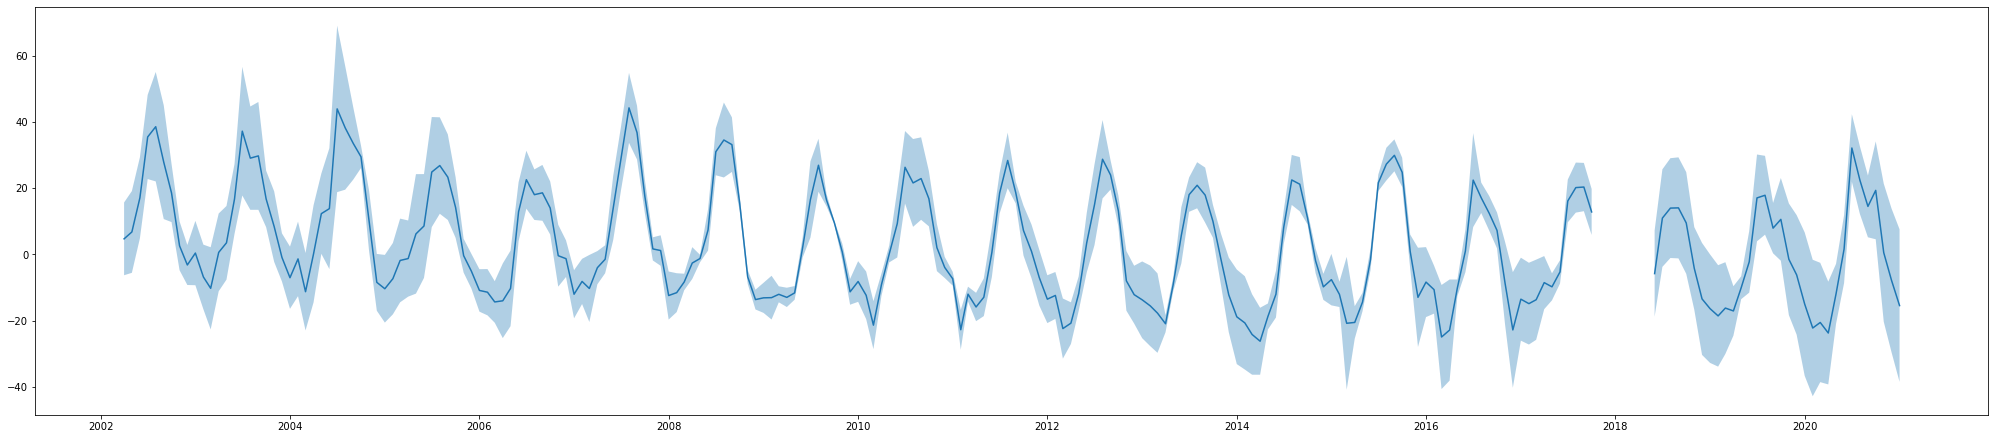

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(35,7.5))
ax.plot(merged_df.time, merged_df.gw_storage)
ax.fill_between(merged_df.time, merged_df.gw_storage - merged_df.uncertainty, merged_df.gw_storage + merged_df.uncertainty, alpha=0.35)

<AxesSubplot:xlabel='time'>

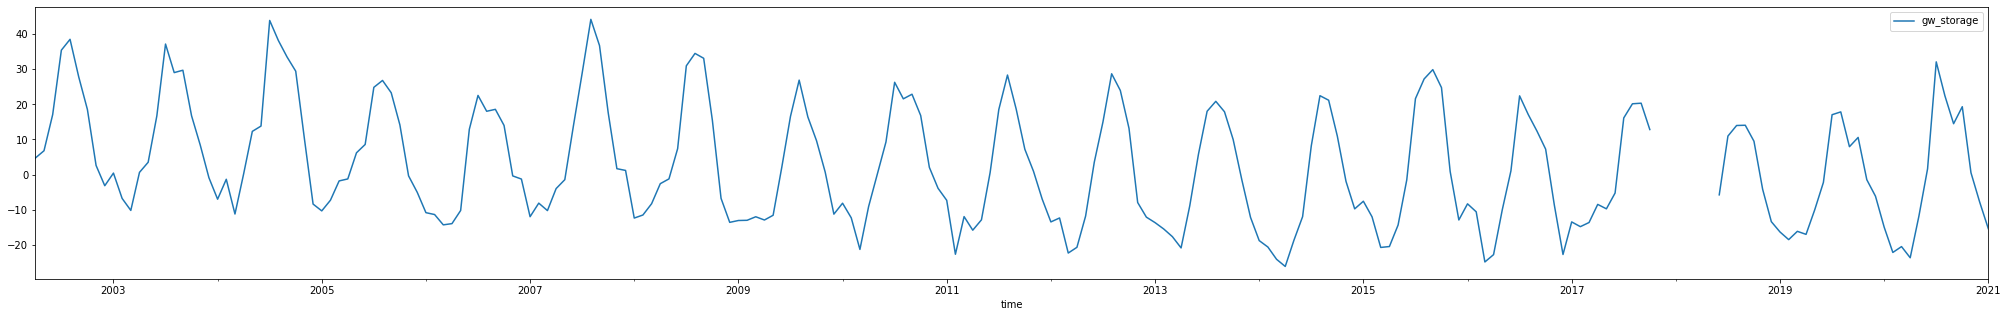

In [61]:
merged_df.plot(x='time', y='gw_storage', figsize=(35,5))